In [1]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
real = pd.read_pickle('../data_geolife/geolife_cut.pkl')
fake = pd.read_pickle('../data_berlinmod/trips_geolife.pkl')

In [3]:
# Load the OSMNX graphs
streets_beijing = ox.load_graphml('beijing_streets_all.graphml', folder='../osmnx_data')

## Simple overview (small map)

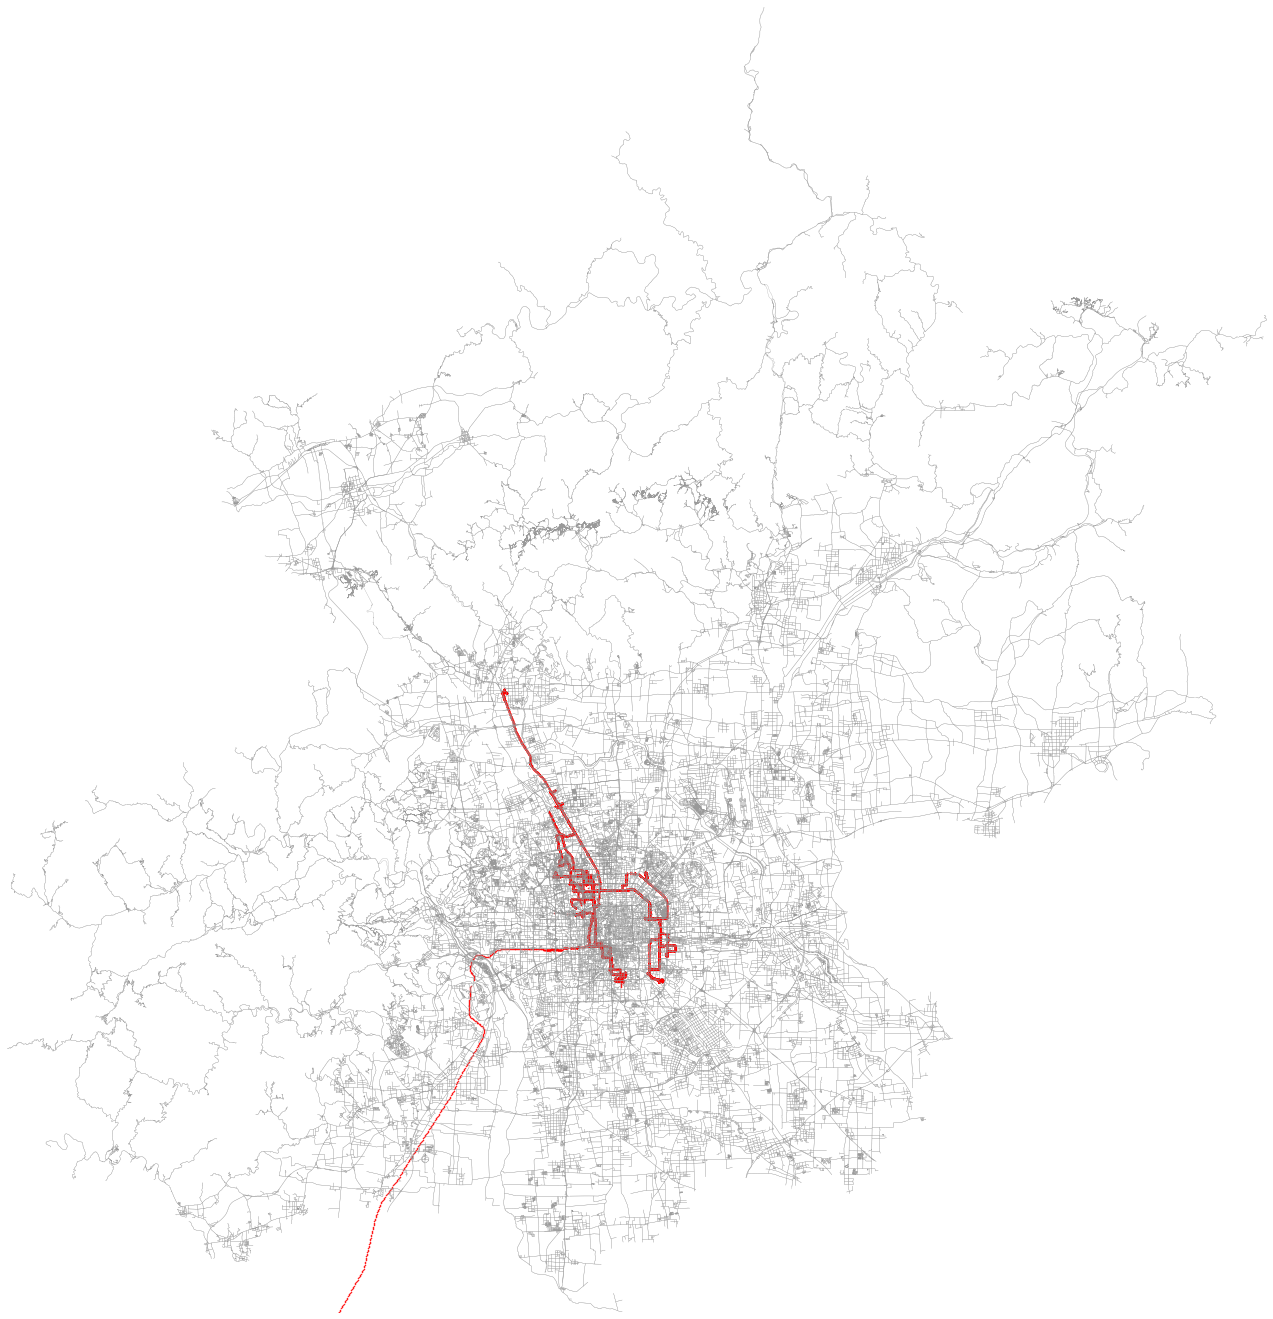

In [4]:
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(real['longitude'], real['latitude'], c='#ff0000', s=0.25, alpha=1.0)

plt.savefig('../../Images/question_overview_geolife_real.png', dpi=100, bbox_inches='tight')

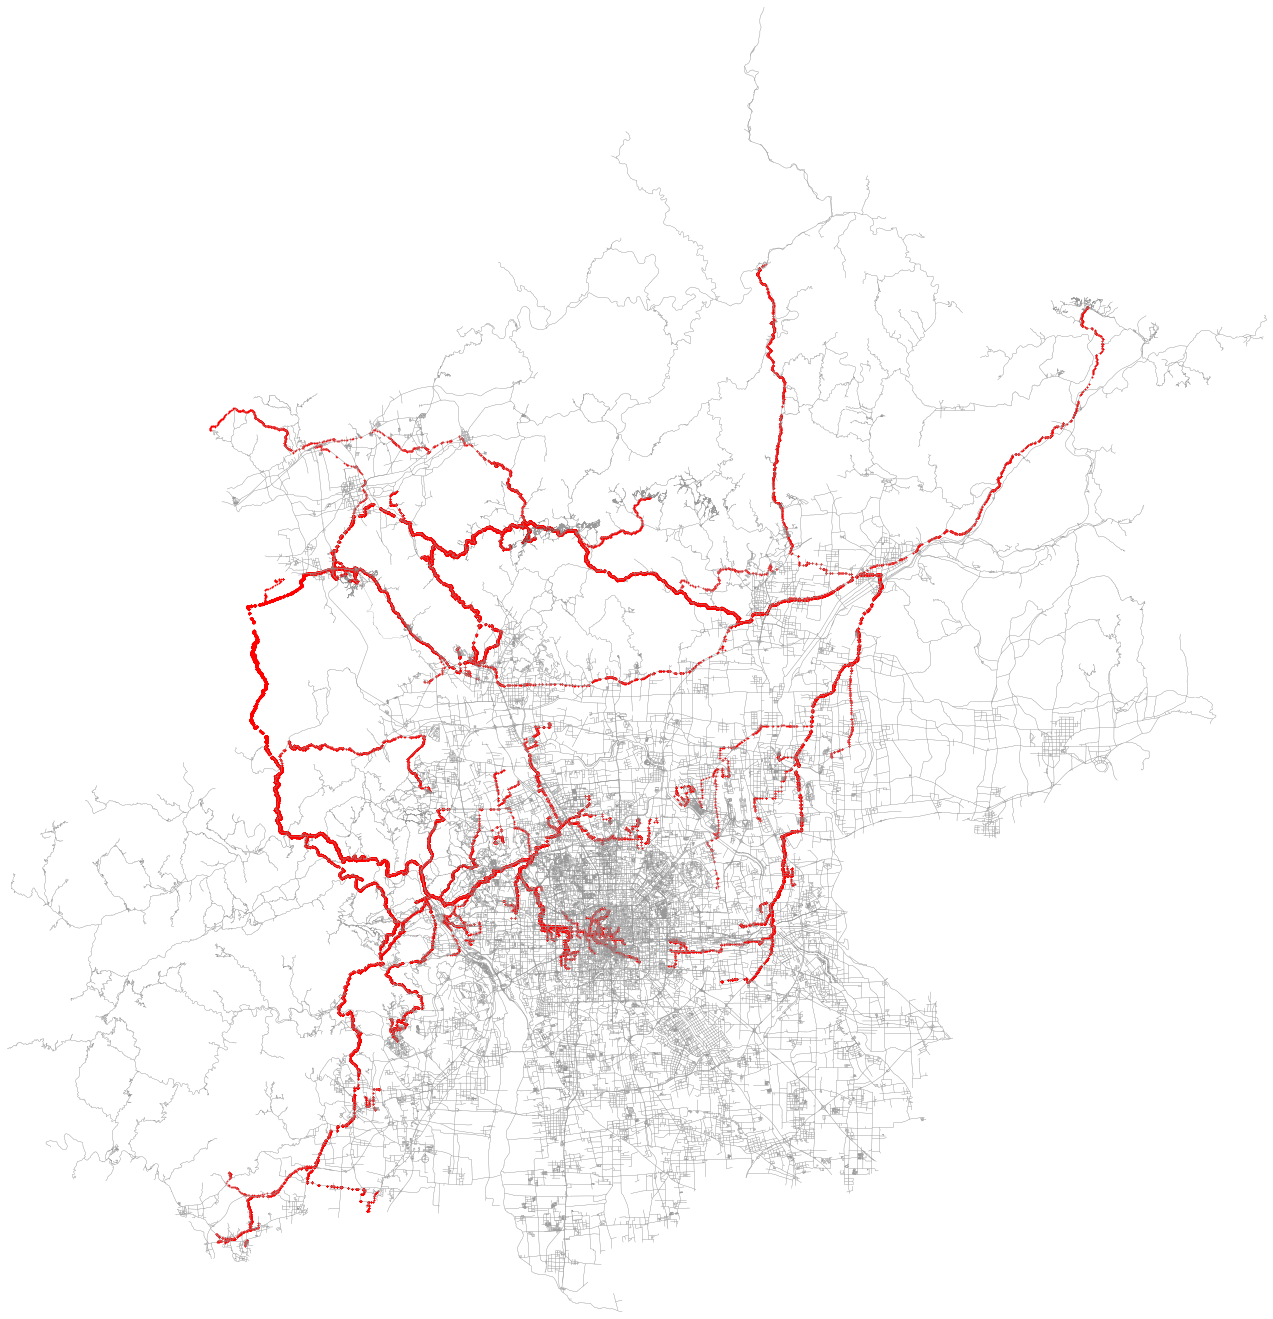

In [5]:
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(fake['longitude'], fake['latitude'], c='#ff0000', s=0.25, alpha=1.0)

plt.savefig('../../Images/question_overview_geolife_berlinmod.png', dpi=100, bbox_inches='tight')

## Histogram of # records in every hour

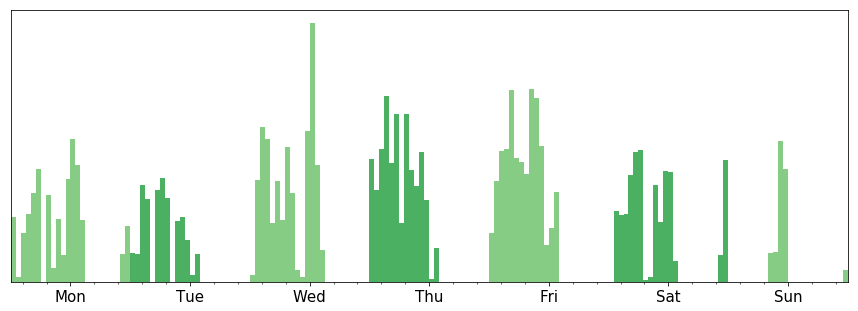

In [6]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(real.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-09-29 00:00:00'), pd.Timestamp('2008-10-05 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-09-29 00:00:00'), pd.Timestamp('2008-10-05 23:59:59'))
plt.xticks([pd.Timestamp('2008-09-29 12:00:00'), pd.Timestamp('2008-09-30 12:00:00'),
           pd.Timestamp('2008-10-01 12:00:00'), pd.Timestamp('2008-10-02 12:00:00'),
           pd.Timestamp('2008-10-03 12:00:00'), pd.Timestamp('2008-10-04 12:00:00'),
           pd.Timestamp('2008-10-05 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)

plt.savefig('../../Images/question_traffic_geolife_real.pdf', dpi=20, bbox_inches='tight')

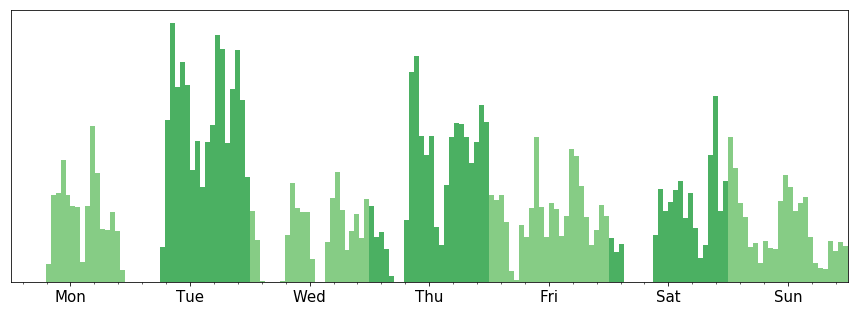

In [7]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(fake.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-09-29 00:00:00'), pd.Timestamp('2008-10-05 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-09-29 00:00:00'), pd.Timestamp('2008-10-05 23:59:59'))
plt.xticks([pd.Timestamp('2008-09-29 12:00:00'), pd.Timestamp('2008-09-30 12:00:00'),
           pd.Timestamp('2008-10-01 12:00:00'), pd.Timestamp('2008-10-02 12:00:00'),
           pd.Timestamp('2008-10-03 12:00:00'), pd.Timestamp('2008-10-04 12:00:00'),
           pd.Timestamp('2008-10-05 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)

plt.savefig('../../Images/question_traffic_geolife_berlinmod.pdf', dpi=20, bbox_inches='tight')

## Distribution of speeds

In [9]:
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles * 1.6

def speed_distribution(ds):
    tmp = ds.reset_index()
    delta_t = tmp.groupby('user')['time'].diff().dt.total_seconds()
    delta_t = delta_t / 3600.0
    prvs_poss = tmp.groupby('user')[['latitude', 'longitude']].shift(1)
    delta_w = haversine(prvs_poss['latitude'], prvs_poss['longitude'], tmp['latitude'], tmp['longitude'])
    speeds = delta_w / delta_t
    
    print(speeds.describe())
    
    plt.figure(figsize=(15, 5))
    plt.hist(speeds, bins=range(0, 150))
    plt.xlim(0, 150)
    plt.yticks([])
    plt.minorticks_on()
    plt.tick_params(labelsize=15.0)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    9.172000e+04
mean              inf
std               NaN
min      0.000000e+00
25%      3.069942e+00
50%      7.043643e+00
75%      2.747174e+01
max               inf
dtype: float64


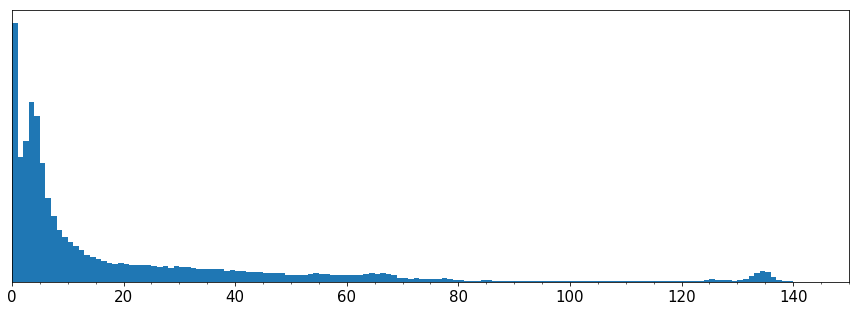

In [10]:
speed_distribution(real)
plt.savefig('../../Images/question_speeds_geolife_real.pdf', dpi=20, bbox_inches='tight')

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    418936.000000
mean         53.630029
std         876.974673
min           0.000000
25%           0.000000
50%          25.706200
75%          39.323641
max      270998.510379
dtype: float64


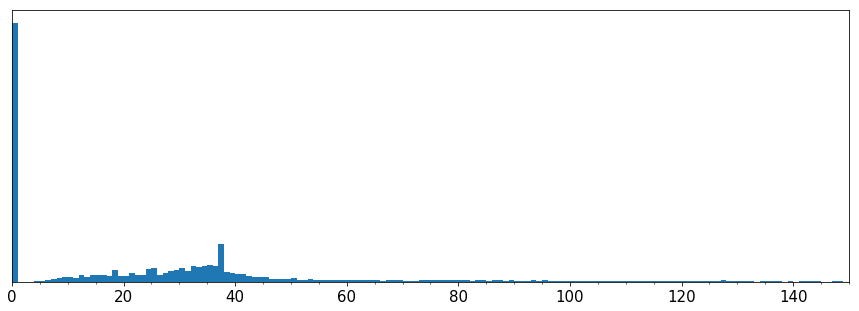

In [11]:
speed_distribution(fake)
plt.savefig('../../Images/question_speeds_geolife_berlinmod.pdf', dpi=20, bbox_inches='tight')

## One user's data

In [14]:
real.index.levels[0]

Int64Index([11, 13, 62, 84, 96, 153], dtype='int64', name='user')

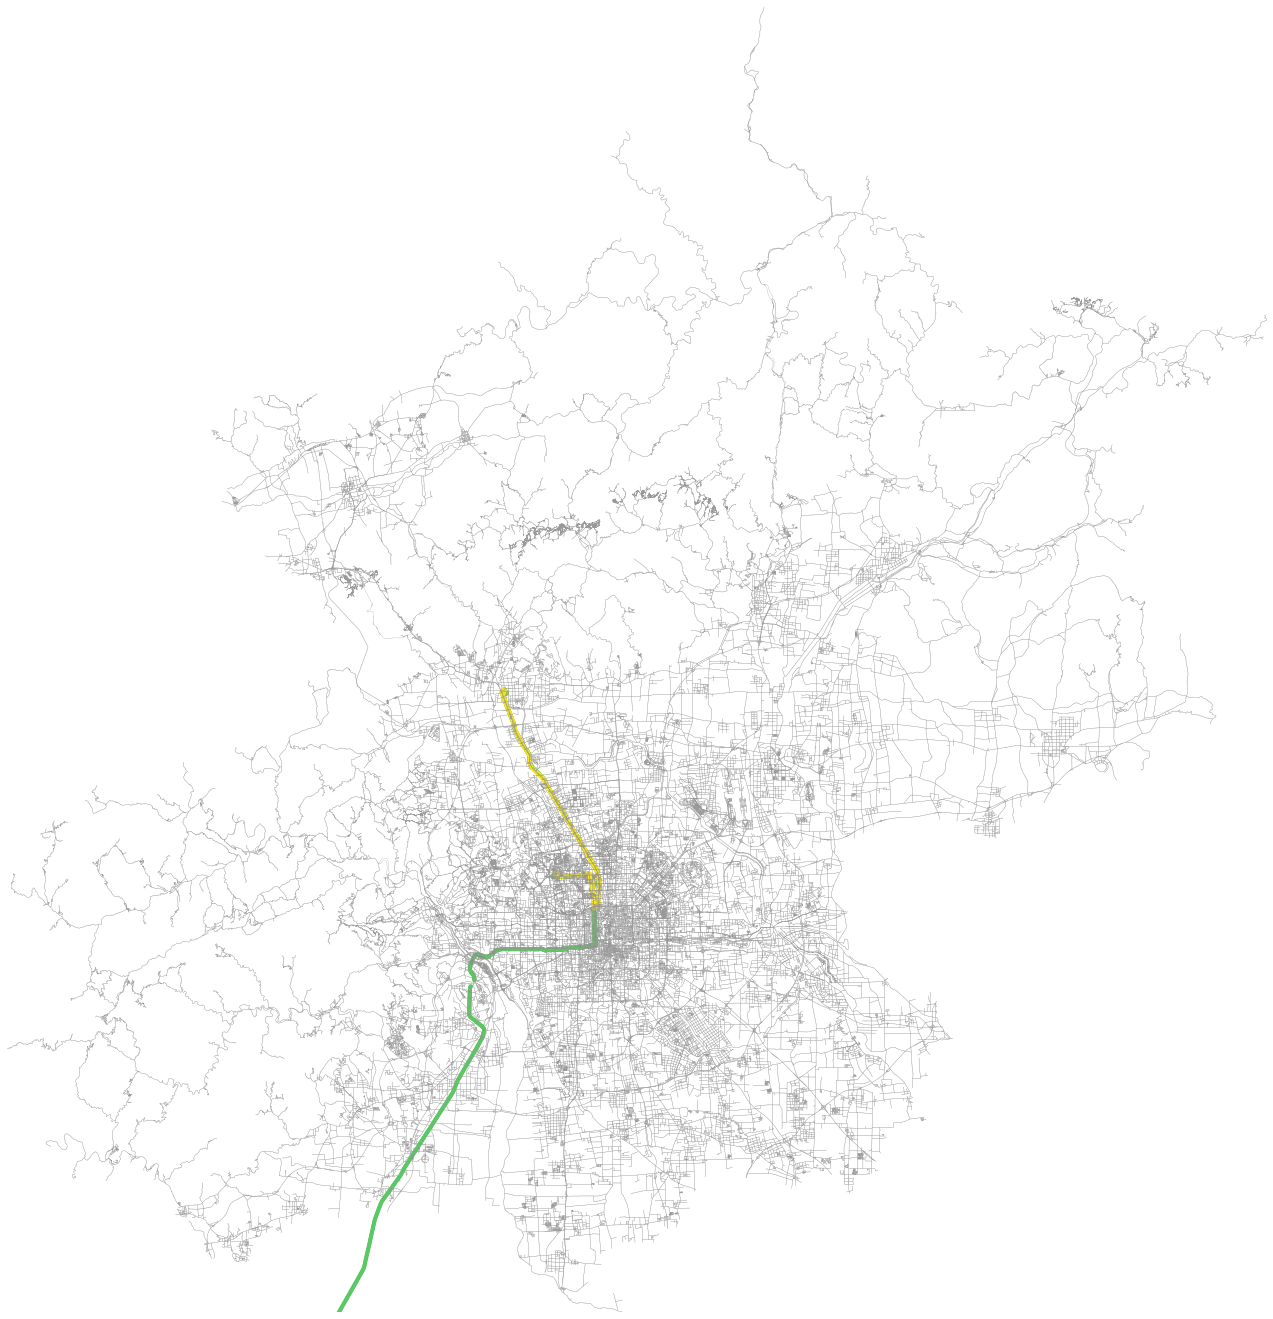

In [12]:
user = 62
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(real.loc[user]['longitude'], real.loc[user]['latitude'], c=real.loc[user].index, s=10.0, alpha=1.0)

plt.savefig('../../Images/question_single_geolife_real.png', dpi=100, bbox_inches='tight')

In [12]:
fake.index.levels[0]

Int64Index([ 1,  4,  7,  8,  9, 11, 13, 14, 16, 18, 19, 21, 22, 24, 25, 26, 27,
            28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 41, 44, 45, 46, 47, 48,
            49, 50],
           dtype='int64', name='user')

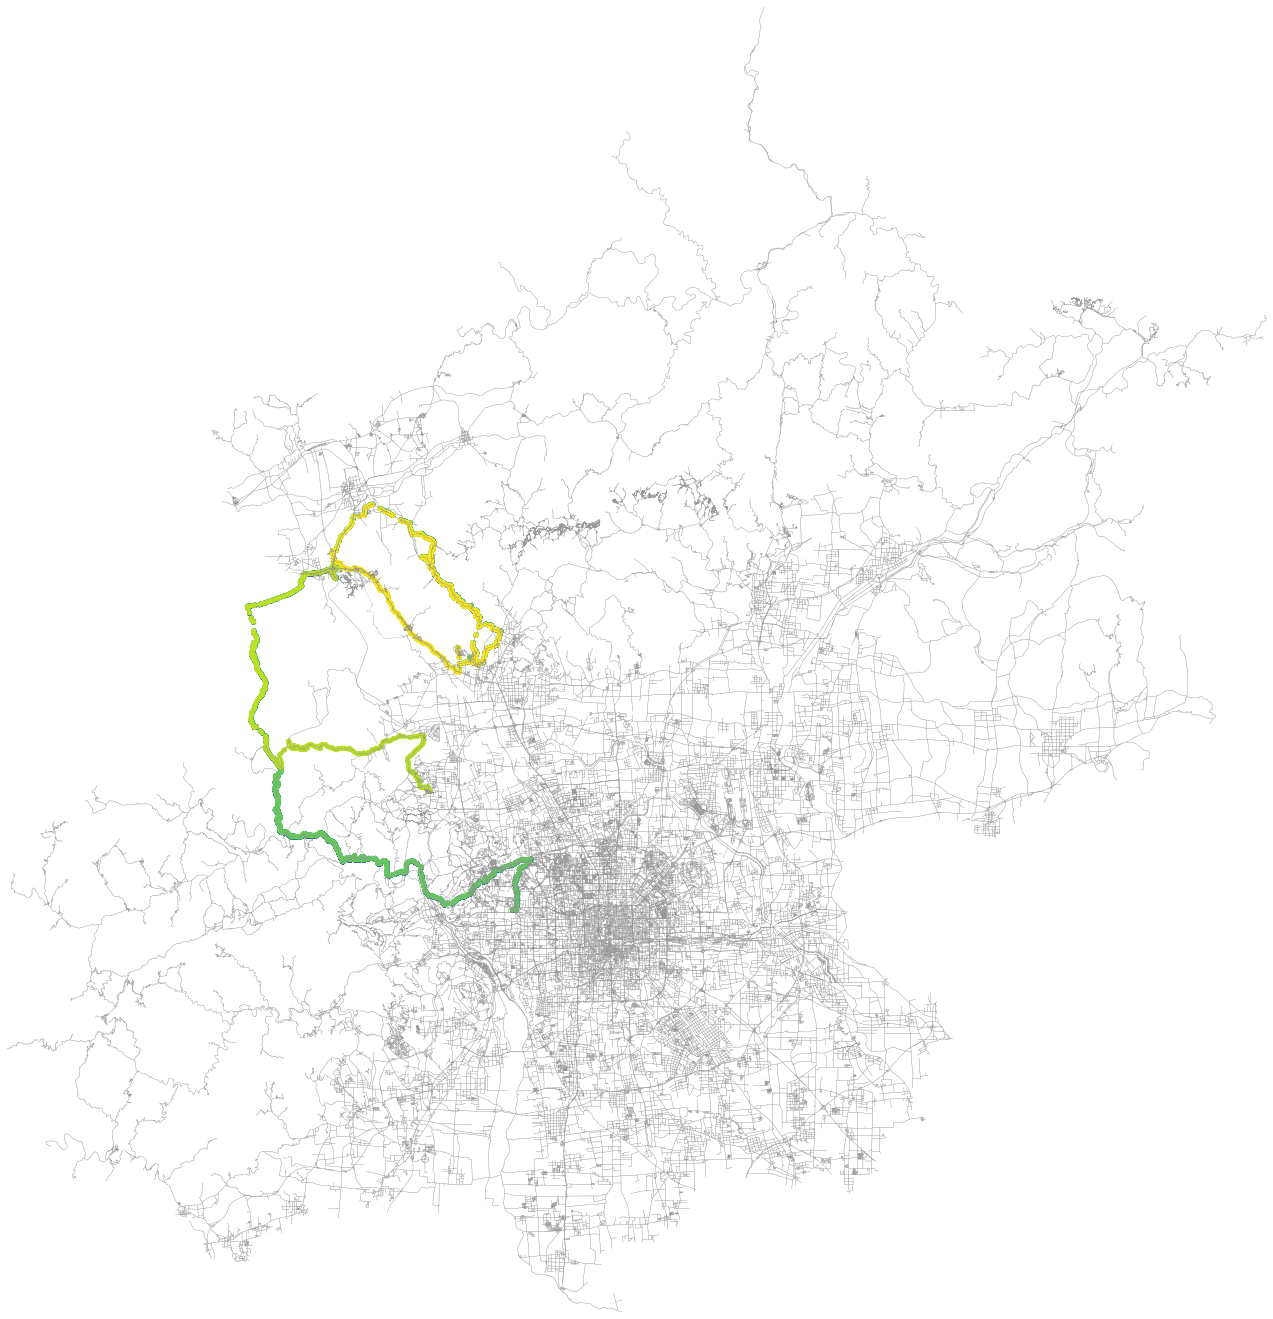

In [13]:
user = 7
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(fake.loc[user]['longitude'], fake.loc[user]['latitude'], c=fake.loc[user].index, s=10.0, alpha=1.0)

plt.savefig('../../Images/question_single_geolife_berlinmod.png', dpi=100, bbox_inches='tight')